# Installs

In [24]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get update

# install cartopy,
# per https://github.com/googlecolab/colabtools/issues/85#issuecomment-709241391 :
# not using `python-cartopy` package as it doesn't include all build dependencies
!apt-get install libproj-dev proj-bin proj-data
!apt-get install libgeos-dev
# shapely needs to be reinstalled to use the same geos install as cartopy (https://github.com/SciTools/cartopy/issues/871)
!pip uninstall -y shapely
!pip install --no-binary shapely shapely
!pip install cartopy

# install cfcrib
# needs eccodes, per https://pypi.org/project/cfgrib/ :

# from https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a 
# (this didn't work)
# !sudo apt-get install libeccodes-dev
#!echo 'export ECCODES_DIR=/usr/src/eccodes' >> ~/.bashrc
#!echo 'export ECCODES_DEFINITION_PATH=/usr/src/eccodes/share/eccodes/definitions' >> ~/.bashrc
#!source ~/.bashrc
#!sudo cp $ECCODES_DIR/lib/libeccodes.so /usr/lib
#!sudo cp /usr/src/eccodes/include/* /usr/include/
#!pip install eccodes-python

# https://pypi.org/project/cfgrib/0.8.4.5/ :
!sudo apt-get install libeccodes0

!python -m eccodes selfcheck
# !pip install eccodes 
!pip install cfgrib

# only needed for demo plots(?):
!pip install cmocean

# from SnowCast Showdown Data Wrangling.ipynb:
# Install GDAL and Geopandas
!apt-get install libgdal-dev 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease

In [2]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [3]:
!python -m eccodes selfcheck

Found: ecCodes v2.6.0.
Library: libeccodes.so.0
Definitions: /MEMFS/definitions
Samples: /MEMFS/samples
Your system is ready.


# Data ingestion


## Get locations for which to retrieve weather data for
from `SnowCast Showdown Data Wrangling.ipynb`:

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [26]:
gridcells = gpd.read_file('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson')
print(gridcells.head())

                                cell_id  ...                                           geometry
0  0003f387-71c4-48f6-b2b0-d853bd4f0aba  ...  POLYGON ((-118.71895 37.07419, -118.71895 37.0...
1  000617d8-8c14-43e2-b708-7e3a69fe3cc3  ...  POLYGON ((-107.07679 37.78042, -107.07679 37.7...
2  000863e7-21e6-477d-b799-f5675c348627  ...  POLYGON ((-119.40167 37.02400, -119.40167 37.0...
3  000ba8d9-d6d5-48da-84a2-1fa54951fae1  ...  POLYGON ((-119.32082 37.43171, -119.32082 37.4...
4  00146204-d4e9-4cd8-8f86-d1ef133c5b6d  ...  POLYGON ((-118.52132 36.65735, -118.52132 36.6...

[5 rows x 3 columns]


In [27]:
traindf = pd.read_csv("/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/train_labels.csv")

traindf = traindf.melt(id_vars=["cell_id"]).dropna().reset_index(drop = True)
traindf.rename(columns = {"cell_id":"cell_id", "variable":"date", "value":"SWE"}, inplace = True)

traindf = traindf.merge(gridcells, how = 'left', on='cell_id')


traindf = gpd.GeoDataFrame(traindf, crs ="EPSG:4326")
traindf

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."
...,...,...,...,...,...
91485,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,central rockies,"POLYGON ((-105.07354 38.87270, -105.07354 38.8..."
91486,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,central rockies,"POLYGON ((-106.10661 39.29804, -106.10661 39.3..."
91487,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,central rockies,"POLYGON ((-107.92120 37.79462, -107.92120 37.8..."
91488,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,other,"POLYGON ((-122.02475 43.89659, -122.02475 43.9..."


Adapted from https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.ipynb :


## Accessing NOAA HRRR data on Azure

The NOAA [HRRR](https://www.nco.ncep.noaa.gov/pmb/products/hrrr/) is a real-time 3km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. 

This notebook provides an example of accessing HRRR data from blob storage on Azure, including (1) finding the data file corresponding to a date and time, (2) retrieving a portion of that file from blob storage which includes the surface temperature variable, (3) opening the file using the `xarray` library, and (4) rendering an image of the forecast.

This dataset is stored in the East US Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

This dataset is documented at <http://aka.ms/ai4edata-hrrr>.

### Set up the environment

We're using `xarray` with the `cfgrib` engine to open the GRIB2 data into an xarray Dataset. `cfgrib` has some binary dependencies so it's easiest to [install with Conda](https://github.com/ecmwf/cfgrib#installation).

In [4]:
import io
from datetime import date, timedelta

import xarray as xr
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# only for demo plots (?):
import cmocean

# for cfgrib:
import eccodes
# Not used directly, but used via xarray
import cfgrib

### Assemble the URL for a single forecast model run

HRRR model data are in files named by date and sector (either CONUS or Alaska). We'll load up yesterday's 2D surface levels model forecast for CONUS run from 12pm UTC. The URL will be assembled based on the path parameters [outlined in our documentation](https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources). 

In [35]:
# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
yesterday = date.today() - timedelta(days=1)
oneyago = date.today() - timedelta(days=int(365.24))
threeyago = date.today() - timedelta(days=int(3*365.24))
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time

longforecast_hour = 48 
# maximum is 48 per https://github.com/microsoft/AIforEarthDataSets/blob/main/data/noaa-hrrr.md#storage-resources

product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"

longforecast_file_path = f"hrrr.t{cycle:02}z.{product}{longforecast_hour:02}.grib2"
longforecast_url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{longforecast_file_path}"

oneyago_file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
oneyago_url = f"{blob_container}/hrrr.{oneyago:%Y%m%d}/{sector}/{file_path}"

threeyago_file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
threeyago_url = f"{blob_container}/hrrr.{threeyago:%Y%m%d}/{sector}/{file_path}"


print(url)
print(longforecast_url)
print(oneyago_url)
print(threeyago_url)

https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220213/conus/hrrr.t12z.wrfsfcf01.grib2
https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220213/conus/hrrr.t12z.wrfsfcf48.grib2
https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20210214/conus/hrrr.t12z.wrfsfcf01.grib2
https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20190215/conus/hrrr.t12z.wrfsfcf01.grib2


In [6]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 2, 14, 2, 23, 43, 28696)

### Determine the file-subset of our variable

The GRIB2 file format stacks binary representations of 2D arrays under a top-level header. This means that instead of downloading and opening the whole file of 170+ variables (150MB+), we can read from a byte offset of just a single variable (or several). The NOAA HRRR data comes with a sidecar index file that specifies start-byte positions for each variable. These files have the same name as the HRRR file, suffixed with `.idx`. 

Let's use this to calculate the offset of the variable we want, before making the data request.

In [38]:
# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

longforecast_r = requests.get(f"{longforecast_url}.idx")
longforecast_idx = longforecast_r.text.splitlines()

oneyago_r = requests.get(f"{url}.idx")
oneyago_idx = oneyago_r.text.splitlines()

threeyago_r = requests.get(f"{threeyago_url}.idx")
threeyago_idx = threeyago_r.text.splitlines()

# Take a peek at the content of the index
print(*idx[0:10], sep="\n")
print()
print(*longforecast_idx[0:10], sep="\n")
print()
print(*oneyago_idx[0:10], sep="\n")
print()

# https://rapidrefresh.noaa.gov/hrrr/ says:
# HRRR implementations at NCEP
#HRRRv1 - 30 Sept 2014
#HRRRv2 - 23 Aug 2016
#HRRRv3 - 12 July 2018
#HRRRv4 - 2 Dec 2020
print(*threeyago_idx[0:10], sep="\n")

1:0:d=2022021312:REFC:entire atmosphere:1 hour fcst:
2:332847:d=2022021312:RETOP:cloud top:1 hour fcst:
3:488642:d=2022021312:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:1 hour fcst:
4:904950:d=2022021312:VIL:entire atmosphere:1 hour fcst:
5:1118332:d=2022021312:VIS:surface:1 hour fcst:
6:2641634:d=2022021312:REFD:1000 m above ground:1 hour fcst:
7:2820295:d=2022021312:REFD:4000 m above ground:1 hour fcst:
8:2964383:d=2022021312:REFD:263 K level:1 hour fcst:
9:3140689:d=2022021312:GUST:surface:1 hour fcst:
10:4448326:d=2022021312:UGRD:250 mb:1 hour fcst:

1:0:d=2022021312:REFC:entire atmosphere:48 hour fcst:
2:519950:d=2022021312:RETOP:cloud top:48 hour fcst:
3:599279:d=2022021312:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:48 hour fcst:
4:1436310:d=2022021312:VIL:entire atmosphere:48 hour fcst:
5:1910406:d=2022021312:VIS:surface:48 hour fcst:
6:3410716:d=2022021312:REFD:1000 m above ground:48 hour fcst:
7:3726956:d=20

In [8]:
# You can see it has a 1-indexed base line number, starting byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
print("Surface temp line:", sfc_temp_idx)
longforecast_sfc_temp_idx = [l for l in longforecast_idx if ":TMP:surface" in l][0].split(":")
print("longforecast_Surface temp line:", longforecast_sfc_temp_idx)


# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]
longforecast_line_num = int(longforecast_sfc_temp_idx[0])
longforecast_range_start = longforecast_sfc_temp_idx[1]


# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None
longforecast_next_line = longforecast_idx[longforecast_line_num].split(':') if longforecast_line_num < len(longforecast_idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None
longforecast_range_end = longforecast_next_line[1] if longforecast_next_line else None

print(f"Byte range: {range_start}-{range_end}")
print(f"longforecast_ Byte range: {longforecast_range_start}-{longforecast_range_end}")

Surface temp line: ['64', '40342675', 'd=2022021312', 'TMP', 'surface', '1 hour fcst', '']
longforecast_Surface temp line: ['64', '42967862', 'd=2022021312', 'TMP', 'surface', '48 hour fcst', '']
Byte range: 40342675-41791259
longforecast_ Byte range: 42967862-44402322


### Request the surface temperature file-subset

Now that we have the byte range of the single variable we want, we can make a traditional GET request to the Azure Blob Storage container, which supports HTTP range headers. We'll have to save this file to disk since [cfgrib does not currently support reading file-like objects](https://github.com/ecmwf/cfgrib/issues/99).

In [12]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)
longforecast_file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

longforecast_headers = {"Range": f"bytes={longforecast_range_start}-{longforecast_range_end}"}
longforecast_resp = requests.get(longforecast_url, headers=longforecast_headers, stream=True)

with longforecast_file as f:
    f.write(longforecast_resp.content)


In [13]:
!ls -l $file.name
!ls -l $longforecast_file.name

-rw------- 1 root root 1448585 Feb 14 02:24 /tmp/tmp_1s2ufr5k
-rw------- 1 root root 1434461 Feb 14 02:24 /tmp/tmp_9ke7f5hl


### Open the GRIB2 file as an xarray dataset

The downloaded file subset is a valid GRIB2 file. Open it with the `cfgrib` engine for `xarray` and we can do traditional `xarray` operations. Setting `indexpath` here to an empty string tells `cfgrib` to open the file without an associated `.idx` file (which doesn't exist, since we just created this subset file).

In [14]:
ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})
longforecast_ds = xr.open_dataset(longforecast_file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})

### Check the dataset value

Let's do a quick check of the distribution of temperature values across the country to make sure things look right.

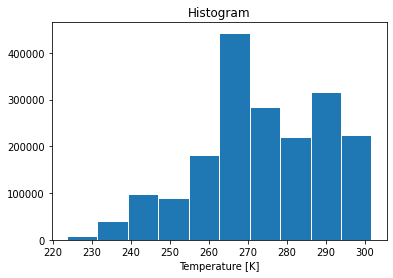

In [15]:
ds.t.plot.hist(edgecolor="white")
plt.show()

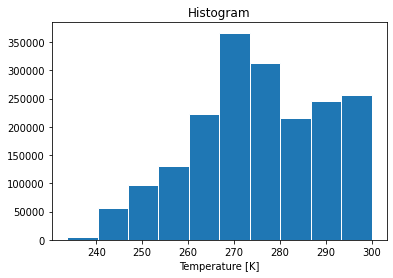

In [16]:
longforecast_ds.t.plot.hist(edgecolor="white")
plt.show()

### Plot an image of the temperature forecast

First, let's create a Cartopy CRS (coordinate reference system) specification from the attributes in the dataset. The HRRR data comes in the Lambert conformal projection. See [this example](https://github.com/blaylockbk/HRRR_archive_download/blob/4105f21ee01ad5a915d9545008fad94cf8af8213/herbie/accessors.py#L69-L78) for more information.

In [19]:
attrs = ds.t.attrs
longforecast_attrs = longforecast_ds.t.attrs

assert attrs['GRIB_gridType'] == 'lambert'
assert longforecast_attrs['GRIB_gridType'] == 'lambert'

# Define the CRS with attributes from the temperate DataArray
prj_kwargs = dict(
    globe=ccrs.Globe(ellipse='sphere'),
    central_latitude=attrs['GRIB_LaDInDegrees'],
    central_longitude=attrs['GRIB_LoVInDegrees'],
    standard_parallels=(attrs['GRIB_Latin1InDegrees'],\
                        attrs['GRIB_Latin2InDegrees'])
)

prj = ccrs.LambertConformal(**prj_kwargs)

Now we can plot the entire CONUS with some overlaid context from `cartopy` and a nice thermal colormap from `cmocean`.

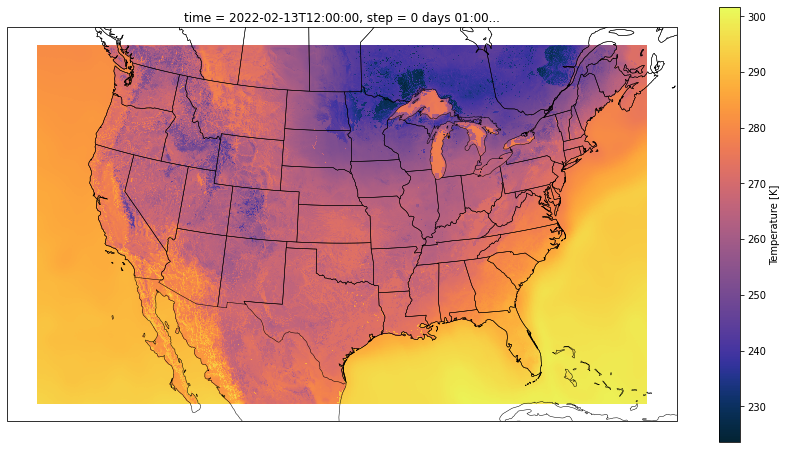

In [18]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

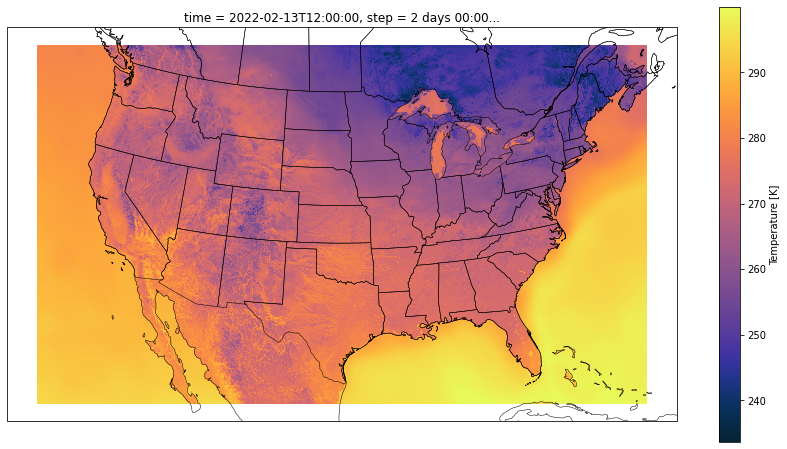

In [20]:
# Ignore some matplotlib deprecation warnings
import warnings; warnings.simplefilter("ignore")

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=prj)
plt_kwargs = dict(x='longitude', y='latitude', cmap=cmocean.cm.thermal, 
                  transform=ccrs.PlateCarree())

longforecast_ds.t.plot(**plt_kwargs, ax=ax)
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
plt.show()

Lastly, let's convert Kelvin to Centigrade, and zoom in on the Southwest where there is the most temperature variation.

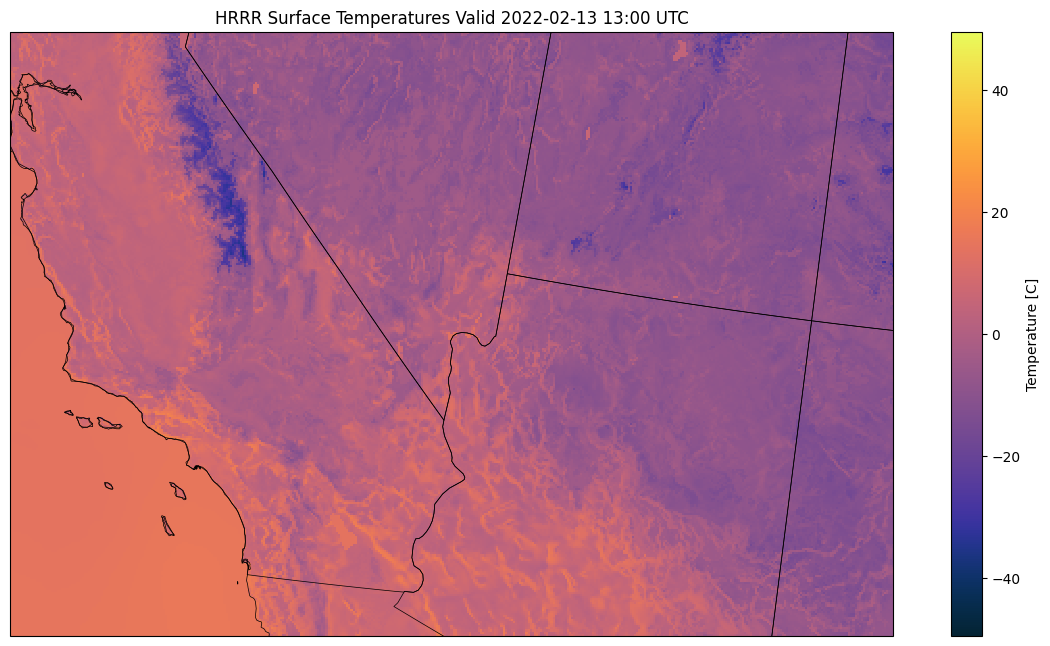

In [21]:
# Increase the dpi a bit for some crisper text
fig = plt.figure(figsize=(15,8), dpi=100)
ax = plt.axes(projection=prj)

# K to C
with xr.set_options(keep_attrs=True):
    t_c = ds.t - 273.15
    t_c.attrs["units"] = "C"

# Add some context and zoom to the SW
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.set_extent([-121, -108, 33, 39], crs=ccrs.PlateCarree())

t_c.plot(**plt_kwargs, ax=ax)
d = ds.coords['valid_time'].values

plt.title(f"HRRR Surface Temperatures Valid {yesterday} {cycle + forecast_hour:02}:00 UTC")
plt.show()

### Additional resources

Check out the [HRRR Archive Download](https://github.com/blaylockbk/HRRR_archive_download) repo for a great collection of utility functions and more documentation about accessing and using this dataset. 